In [122]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\USER\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['hist', 'gradient']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## The Dataset

To keep the blog post concise and focussed I added explanations in the cells explaining the data loading. This is not part of the blog post.

### Downloading the data

The data is available in a `.data` file, but it's actually a `csv`.

In a Jupyter Notebook you can execute shell commands by putting an `!` at the beginning of the cell. If you're not using a notebook (you should), then you can remove the `!` from the following command.

Downloading files can be done with a little utility program called `wget`. By passing `-O` you can specify the filename of the downloaded file. I used the `csv` extension because it's a csv file, but any extension will do.

To download the data execute the following cell:

In [123]:
!wget -O dataset.csv https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data

'wget' is not recognized as an internal or external command,
operable program or batch file.


Let's look at what that looks like:

In [124]:
!head -3 dataset.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


We'll see the corresponding column names in a second.

### Loading the data

Now to load the data we use a library called `pandas`. This library can do many things related to data loading, but I'll focus on the CSV reader in this post.

In [125]:
import pandas as pd

To read a csv file use `pd.read_csv()`. A few interesting parameters:

* `filepath_or_buffer`: path to the csv file.
* `sep=','`: the separator, defaulted to commas. If your CSV file had tabs in them, for example, pass `\t`.
* `columns`: by passing `columns=None` pandas will also read the first row in the file instead of skipping it assuming it contains headers.
* `names`: custom column names for the dataset.

Since our dataset is separated by commas we won't pass anything for `sep`. We do pass the column names in `names` though so it's easier to select input and output columns later on. Because we pass `names`, pandas knows our CSV does not contain a header row and therefore it also reads the first line.

In [126]:
df = pd.read_csv('breast-cancer-wisconsin.data', names=[
  "id number",
  "Clump Thickness",
  "Uniformity of Cell Size",
  "Uniformity of Cell Shape",
  "Marginal Adhesion",
  "Single Epithelial Cell Size",
  "Bare Nuclei",
  "Bland Chromatin",
  "Normal Nucleoli",
  "Mitoses",
  "Class"
])

Note the variable name `df`. It stands for `DataFrame`: a Pandas object for data.

Now let's inspect the DataFrame. `df.head()` prints out the first 5 elements:

In [127]:
df.head()

,id number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


### Data cleaning

If we take a closer look at the DataFrame we notice some columns have `?`, which of course means a value is unknown. Question marks are not understood by Pandas, so we replace them with `nan`, which Pandas does understand.

In [128]:
df = df.replace('?',np.NaN)

If we now count the missing values for each column, we see that `Bare Nuclei` misses 16 values.

In [129]:
df.isna().sum()

id number                       0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

We will fill the missing values in a second once we have the data in numpy arrays.

### To NumPy &amp; feature selection

DataFrames by themselves are a great tool for organizing and manipulating data, but in order to use it for machine learning we usually need to convert the data to some other object. Numpy arrays in this case.

Convering a pandas object to numpy is done by calling `to_numpy()`.

Note that we select all columns, except for id number and class, as features. We use the "Class" column as labels. Note that we did not select the id number column for either because that information should be completely unrelated to the diagnosis. In the rare event features like these boost accuracy it's because of a coincidence and it would not generalize well to the real world.

In [130]:
X = df[["Clump Thickness",
  "Uniformity of Cell Size",
  "Uniformity of Cell Shape",
  "Marginal Adhesion",
  "Single Epithelial Cell Size",
  "Bare Nuclei",
  "Bland Chromatin",
  "Normal Nucleoli",
  "Mitoses"
]].values.astype(np.float32)
X.shape

(699, 9)

There are multiple techniques to deal with the missing data.

* Delete instances with missing values.
* Fill missing values in a column with the _mean_ of that column.
* Fill missing values in a column with the _mode_ of that column.
* Fill missing values in a column with the _median_ of that column.

Since this dataset is relatively small deleting rows will have a big impact. The mean is very sensitive to outliers, and the mode may not always be present---especially in continuous metrics. That's the reason I chose to use the median of each column to fill up the missing values, but feel free to play around with that yourself.

To replace missing values we first need to find the indicies (`idx`) that have missing values. Once we find these we can replace the items at those indices with the `nanmedian` of each column (axis = 0).

In [131]:
idx = np.where(np.isnan(X))
X[idx] = np.take(np.nanmedian(X, axis = 0), idx[1])

In [132]:
y = df['Class'].values
y.shape

(699,)

In [133]:
y[0]

2

### Cleaning `y`

The negatives (label: 0) are labelled 2 and the positives (label: 1) are labelled 4. Our model won't work with these values so we convert them to $y^{(i)} \in \{1, 2\}$.

In [134]:
# we only run this cell once.
if y[0] == 2:
  y = np.array(y == 4, dtype=np.float32)

In [135]:
y.shape, y[:10]

((699,), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32))

### Bias factor

In [136]:
X = np.hstack((np.ones((len(X), 1)), X))

In [137]:
X[:10]

array([[ 1.,  5.,  1.,  1.,  1.,  2.,  1.,  3.,  1.,  1.],
       [ 1.,  5.,  4.,  4.,  5.,  7., 10.,  3.,  2.,  1.],
       [ 1.,  3.,  1.,  1.,  1.,  2.,  2.,  3.,  1.,  1.],
       [ 1.,  6.,  8.,  8.,  1.,  3.,  4.,  3.,  7.,  1.],
       [ 1.,  4.,  1.,  1.,  3.,  2.,  1.,  3.,  1.,  1.],
       [ 1.,  8., 10., 10.,  8.,  7., 10.,  9.,  7.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  2., 10.,  3.,  1.,  1.],
       [ 1.,  2.,  1.,  2.,  1.,  2.,  1.,  3.,  1.,  1.],
       [ 1.,  2.,  1.,  1.,  1.,  2.,  1.,  1.,  1.,  5.],
       [ 1.,  4.,  2.,  1.,  1.,  2.,  1.,  2.,  1.,  1.]])

### Stats

In [138]:
m, n = X.shape
K = 2
K, m, n

(2, 699, 10)

## Training a model

In [139]:
theta = np.zeros(n)

### The model

In [140]:
def g(z):
  """ sigmoid """
  return 1 / (1 + np.exp(-z))

In [141]:
def h(X, theta):
  return g(X @ theta)

In [142]:
preds = h(X, theta)
preds.shape, preds[:10]

((699,), array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))

### Cost function & gradients

In [143]:
def J(preds, y):
  return 1/m * (-y @ np.log(preds) - (1 - y) @ np.log(1 - preds))

In [144]:
def compute_gradient(theta, X, y):
  preds = h(X, theta)
  gradient = 1/m * X.T @ (preds - y)
  return gradient

In [145]:
compute_gradient(theta, X, y)

array([ 0.15522175, -0.27181688, -0.69885551, -0.65808298, -0.509299  ,
       -0.21888412, -0.8676681 , -0.34263233, -0.58798283, -0.09799714])

In [146]:
preds = h(X, theta)
J(preds, y)

0.6931471805599452

### Training loop

In [147]:
hist = {'loss': [], 'acc': []}
alpha = 0.1

for i in range(100):
  gradient = compute_gradient(theta, X, y)
  theta -= alpha * gradient

  # loss
  preds = h(X, theta)
  loss = J(preds, y)
  hist['loss'].append(loss)

  # acc
  c = 0
  for j in range(len(y)):
    if (h(X[j], theta) > .5) == y[j]:
      c += 1
  acc = c / len(y)
  hist['acc'].append(acc)

  # print stats
  if i % 10 == 0: print(loss, acc)

0.7306617045761894 0.3447782546494993
0.4650800130797292 0.8469241773962805
0.38340821789823426 0.9055793991416309
0.35347237289196304 0.9141630901287554
0.33271666973853586 0.9184549356223176
0.31688063434698455 0.9256080114449213
0.30406577744783675 0.9256080114449213
0.2932708495641543 0.9313304721030042
0.2839128193761681 0.9298998569384835
0.2756270947419847 0.9313304721030042


### Training evaluation

Text(0.5, 0, 'accuracy')

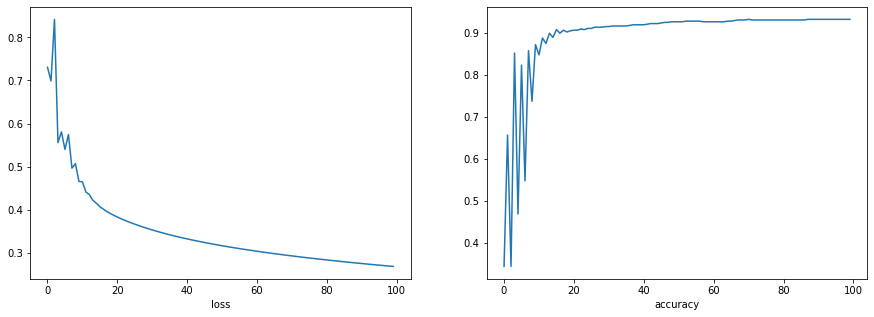

In [148]:
figsize(15, 5)
subplot(1, 2, 1)
plot(hist['loss'])
xlabel('loss')
subplot(1, 2, 2)
plot(hist['acc'])
xlabel('accuracy')

### Final performance

In [149]:
hist['loss'][-1], hist['acc'][-1]

(0.2688861031735936, 0.9313304721030042)

## Evaluation metrics

#### Accuracy

In [150]:
preds = h(X, theta) > 0.5
(preds == y).sum() / len(y)

0.9313304721030042

#### F1

In [151]:
def precision(preds, labels):
  tp = ((preds == 1) == (y == 1)).sum()
  fp = ((preds == 1) == (y == 0)).sum()
  return tp / (tp + fp)

precision(preds, y)

0.9313304721030042

In [152]:
def recall(preds, labels):
  tp = ((preds == 1) == (y == 1)).sum()
  fn = ((preds == 0) == (y == 1)).sum()
  return tp / (tp + fn)

recall(preds, y)

0.9313304721030042

In [153]:
def f1(preds, labels):
  return 2 * (precision(preds, labels) * recall(preds, labels)) / (precision(preds, labels) + recall(preds, labels))

f1(preds, y)

0.9313304721030042

## Optimizing model performance

In [154]:
recalls = []
for p in range(100):
  preds = (h(X, theta) > (p / 100))
  r = recall(preds, y)
  recalls.append(r)

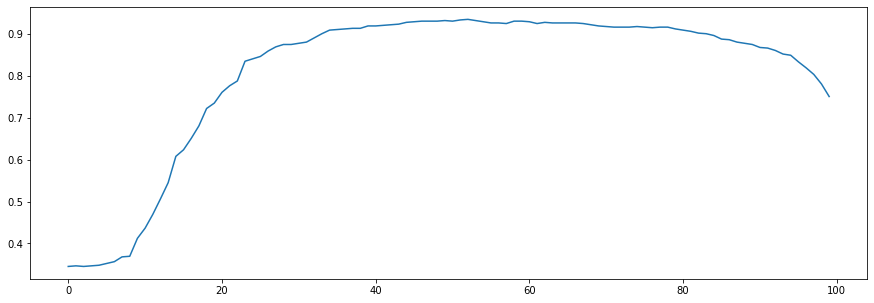

In [155]:
plot(recalls)

In [160]:
preds = h(X, theta) > 0.52
recall(preds, y)

0.9356223175965666

## Graphics

The rest of the notebook is not directly related to the concept. This section just shows how I generate graphics for the blog post.

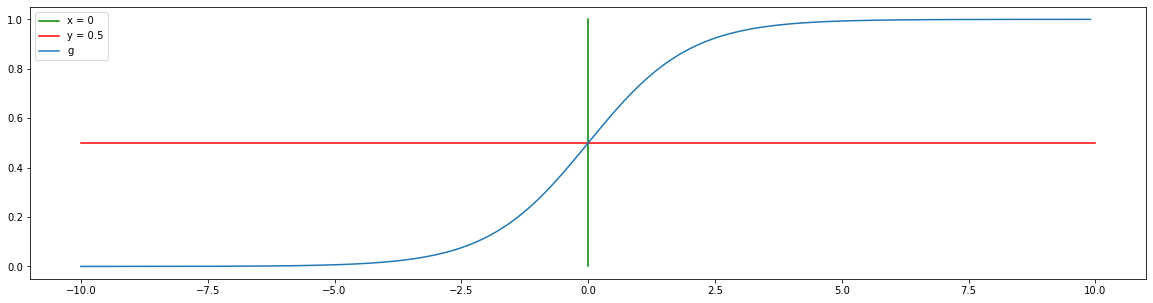

In [157]:
figsize(20, 5)
x = np.arange(-10, 10, 0.1)
plot((0, 0), (0, 1), 'g-', label='x = 0')
plot((-10, 10), (0.5, 0.5), 'r-', label='y = 0.5')
plot(x, g(x), label='g')
legend()

---

By [Rick Wierenga](https://twitter.com/rickwierenga/)